# SIXT33N
## Phase 2: System Identification

### EE 16B: Designing Information Devices and Systems II, Spring 2018

**Name 1**:

**Login**: ee16b-


**Name 2**:

**Login**: ee16b-

## Table of Contents

* [Introduction](#intro)
* [Part 1: The SIXT33N Car](#part1)
* [Part 2: Power, Sensor, and Actuator Circuits](#part2)
* [Part 3: Sensor Verification](#part3)
* [Part 4: Changing to Battery](#part4)
* [Part 5: Open Loop Data Collection and Parameter Estimation](#part5)
* [Part 6: Determining the Operating Point](#part6)

<a id='intro'></a>
## Introduction

In this phase we will
- build the SIXT33N chassis, sensors (wheel encoders), and actuators (motor drivers)
- test the encoders to verify our sensing readings are accurate.
- model the the car as an open loop system.
- collect data and determine the parameters of our model using least-squares.

**Remember to document all design choices you made and explain them in the project report.**

<a id='part1'></a>
## <span style="color:blue">Part 1: The SIXT33N Car</span>

### Materials
- Chassis kit
- 2 Photointerrupters
- Soldering iron + solder

Build the SIXT33N car from the kit. The instructions can be found in the ipython notebook called `SIXT33N_Car_Instructions`.

<a id='part2'></a>
## <span style="color:blue">Part 2: Power, Sensor, and Actuator Circuits</span>

### Materials
- 2 C2690A NPN BJTs (Bipolar Junction Transistor)
- 2 IN4001 Diodes
- 2 1.5k$\Omega$ resistors
- 1 switch

You do not want to run SIXT33N's motors off your laptop. Instead, **you will run the car off of two 9V batteries**. One of the batteries is used exclusively for the motors, and the other for powering the Launchpad and microphone front end. Using the same voltage source could potentially reset the Launchpad when the power draw spikes from the motors. The power distribution is shown in the diagram below. The front end circuit will use both the 5V regulator output and the Launchpad's 3.3V pin.

**Note that all the grounds (e.g. the grounds of the two batteries) are still connected.**

<br/><br/>

<center>
<img width="700px" src="images/proj-power.png">
</center>

## Motor Drivers
To be able to move, the car needs motor drivers. The DC motors we use are usually driven by a Pulse Width Modulated (PWM) signal which will be produced by the Launchpad. A PWM signal is simply a square wave at a certain frequency but with variable duty cycle (percentage time the signal is high in a period). Since the motors need a lot of power, as mentioned before, we will connect the motors to their own separate 9V battery and an NPN transistor.

The <a href="https://www.allaboutcircuits.com/textbook/semiconductors/chpt-4/bipolar-junction-transistors-bjt/">NPN bipolar junction transistor</a> behaves a little different from the NMOS you are familiar with, but both transistors can still be considered switch-like. An NMOS uses voltage to control whether the switch is off or on, whereas a BJT uses current to control the switch. However, BJTs burned out by running too much current through them, so a $1.5\mathrm{k}\Omega$ resistor is used to limit the current. 

### Your tasks

- **Construct the circuit below for both wheels using the <a href="https://www.fairchildsemi.com/datasheets/KS/KSC2690A.pdf">C2690A</a> NPN BJT on the breadboard**.
    - The pin diagram of the BJT is reproduced below.
    - Note that the diagram has the markings in the black plastic part facing up.
- **Use a different breadboard row for the 9V for the motors than the 9V for the voltage regulator.**
- **Add a switch between 9V and the motor drivers.**
- **Remove the 9V power supply from the 5V regulator (if it's connected), and move it to the switch to test the motors.**
    - We have limited rechargeable 9V batteries, so use the power supply when working at your lab station for long periods of time.
- **Set a current limit of 400mA.**
    - The motors can each draw 100-200mA.

## <span style="color:red">IMPORTANT: Make sure to match the Base, Emitter, and Collector accordingly to the schematic.</span>

<center>
<img width="250px" src="images/proj-bjt.png">
</center>

<center>
<img width="250px" src="images/motor-drive-with-switch.jpg">
</center>

A <a href="https://www.allaboutcircuits.com/textbook/semiconductors/chpt-3/introduction-to-diodes-and-rectifiers/">diode</a> is a component that only conducts current one way. This diode is needed because of the inductive characteristics of the motor. If the motor is on and we turn it off, the inductive behavior of the motor maintains the current and we need a way to dissipate it.

The diagram for the diode is shown below. Note that the diode has a direction - be careful which terminal is attached to the 9V power supply.

<center>
<img width="500px" src="images/proj-diode.png">
</center>

The motor is reversible so connect it any way for now. If it turns out to go backwards later, just reverse the two terminals of the motor.

### Your tasks

- Test the motor drivers. For each motor driver:
    - Connect the node of the resistor labeled `MSP430 output pin` in the schematic to the function generator.
    - Set the function generator to output a **1kHz square wave with 3Vpp, 1.65V offset, 80% duty cycle**.
    - Changing the duty cycle should control the speed of the wheels.
    - Remember to **set the output of the function generator to high impedance**.
- **<span style="color:red"><b>Make sure that both motors drive as expected. They might not go at the same speed - our control loop will fix that.<b></span>**
- Once the motor circuit is verified,
    - **leave the resistor terminals that are supposed to be driven by the Launchpad pins connected to ground**
    - This keeps the motors off.


## Wheel Encoders

Put the photointerrupter modules in their slots as shown below.
<br/><br/>
<center>
<img width="400px" src="images/proj-car-encoder1.jpg">
</center>

Use 4 female-male jumper wires per encoder. You should **twist all three wires from the encoder to the breadboard together** - this will help shield the signal wire from external noise sources.
* Connect the 'G' (ground) pins to ground on your breadboard, ideally closely to the ground of your Launchpad battery.
* Connect the 'V' (voltage) pins to the 3.3V pins of your breadboard, ideally closely to the 3.3V jumper coming from the Launchpad.
* Connect the 'S' (signal) pins to the breadboard.
* Then connect the left pin from the breadboard to `P6.1` and the right signal pin to `P6.2`.

<a id='part3'></a>
## <span style="color:blue">Part 3: Sensor Verification</span>

### Materials
- Launchpad + USB cable

In general, there are two major types of error in sensing the car's trajectory. The first is noise in the sensor signals. The second is from mechanical differences between the two sides of the car.

In this section we will test for and fix the first type of noise. The mechanical type primarily affects performance over long distances, so we can compensate for it after implementing closed-loop control.
 
- Disconnect the 5V pin of the Launchpad from the 5V regulator (if it's connected).
    - **Connect the left motor's BJT to `P2.0` and the right motor's BJT to `P1.5`.**
    - Connect the USB.
    - It's ok to momentarily connect both at the same time so you don't lose data after a test on the ground.
- Remove the encoder wheels if they are on the car, and upload **`encoder_test_0_ticks.ino`** to the Launchpad.
- Open the serial monitor, **set the baud rate to `38,400`**, and follow the instructions on the serial monitor.
- **Your car wheels are going to move in this step.**
    - Make sure that the car is suspended above the desk. Don't let your car jump off the bench.

Press reset, press switch 1 (the bottom left button, labeled P2.1, s1), and wait for the tests to run.

If your encoders are functioning properly, the serial monitor should print "Success" after each phase, and display all 0's (or at least no more than a few ticks) for the ticks per phase. Note that if your car is mis-wired, this could be a false negative.

Attach the encoder disk as shown below. Make sure to remove the paper sticker (yes, it does come off) before you attach it. If some of the holes in the encoder were not fully cut out, use the flat end of the screwdriver (it's reversible!) to push the material out.

Now rerun the tests. If your car is connected correctly, **the tests should fail with several hundred encoder ticks**, ruling out a false negative.

<img width="400px" src="images/proj-car-encoder2.jpg">

<a id='part4'></a>
## <span style="color:blue">Part 4: Changing to Battery</span>

### Materials
- 2 9V rechargeable batteries + battery leads (knotted)

Now we want to use 9V batteries to run the car on the ground.
- Take the power supply off the motor drivers.
    - **Never connect both the power supply and the battery at the same time. Don't do it.**
- Connect the battery leads.
    - The grounds of the 9V battery leads should go to the ground rail of the circuit.
- Knot your battery leads as in the image below.
    - This will drastically decrease the chance that the leads will accidentally short and kill your battery.

<img width="400px" src="images/proj-batt-lead.jpg">

**<span style="color:red">Use your multimeter again to check that the output of your regulator is still 5V and nothing was shorted.</span>**

Note that **if you are testing things at the bench, use the benchtop power supply.** The battery does not contain a lot of energy and the motors take a lot of power. If you leave it running it will only last a little over an hour. If the voltage of the battery drops below 7.8V, ask for a new one from your GSI.

<a id='part5'></a>
## <span style="color:blue">Part 5: Open Loop Data Collection and Parameter Estimation</span>


Before trying to control the SIXT33N, we will first characterize the open loop reponse of the system. To make modeling easier, we will separate the models of the two wheels. The model that we create for both wheels can be identical because they are symmetric, but will have different parameters to account for subtle differences in the hardware. The distance that each wheel has moved (measured in number of encoder ticks) at sample $k$ will be denoted using $d_L[k]$ and $d_R[k]$ for the left and right wheels respectively. The open loop model has an input $u[k]$ for PWM level and an output for the distance for that wheel (thus the $C$ matrix is just the identity matrix).

$$d_L[k+1] = d_L[k] + \theta_L u_L[k] - \beta_L$$
$$d_R[k+1] = d_R[k] + \theta_R u_R[k] - \beta_R$$

All distances are measured in cm (each encoder tick corresponds to ~1cm of wheel travel) while time is measured in ms. As you can see, there are 2 unknown variables for each wheel, namely $\theta$ and $\beta$. To determine these parameters, we will perform least squares regression on each row. You will do this for both wheels separately.

Now, you will collect the data by uploading the sketch **`dynamics_data.ino`**. Glance through the sketch - it records the position of each wheel while varying the input signal $u[k]$ linearly from HIGH_PWM to LOW_PWM and back up. The sampling period is $T_s = 500\mathrm{ms}$. A long sampling period is used to minimize error due to quantization, the rounding error from measuring only integer encoder ticks.

**Important: For this first test, make sure that you are using the first set of 5 parameters in code block `SID1`** (abbreviated from System ID 1). These parameters will sweep through the whole range of PWM values, from maximum to minimum and back to maximum, while collecting only 1 sample per PWM. This means **the car will stop for a short time in the middle of the test.**

- Place the car in a large empty space and hit the reset button. 

After a few seconds it will start moving and collecting data. The car will probably turn in a circle, even when the same PWM is applied to both wheels, because the physical characteristics of the two sides of the car are different. This is fine though, and we will fix it in later sections using closed-loop control.

- When the car stops moving, bring it to your PC.
- Connect the Launchpad to your PC using a USB cable.
- Remove the Launchpad's 5V from the voltage regulator.
- Close (if it's open) and reopen the serial monitor in Energia.
- **Copy the data between two "Start" lines to a text file called `data_coarse.txt`.**
    - This data will be used in the cells below.

The example plot below shows an example of extreme differences between the two wheels. Here, the 1.5$\mathrm{k\Omega}$ resistors at the bases of the BJT's were replaced by 1$\mathrm{k\Omega}$ (left) and 3$\mathrm{k\Omega}$ (right) resistors. The smaller resistor drives the BJT with more current ($I=\frac{V}{R}$, smaller $\downarrow R\implies \uparrow I$), and oppositely for the larger resistor. This mimics a car with a much stronger left wheel than right wheel. The plot shows the drastic difference in response between the two wheels, and how the wheels behave when slowing to 0 versus speeding up from 0.

<img width="400px" src="images/example_coarse_data.png">

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

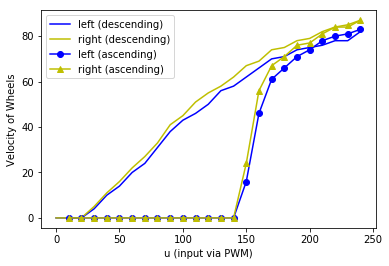

In [3]:
with open('data_coarse.txt', 'r') as file:
    data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])

# compute velocity from distances
dleft  = data[:, 1]
dright = data[:, 2]
vleft  = dleft[1:]  - dleft[:-1] 
vright = dright[1:] - dright[:-1]
u = data[1:, 0].reshape((-1, 1)) # duty cycle
left_des, left_asc = np.array_split(vleft, 2)
right_des, right_asc = np.array_split(vright, 2)
u_des, u_asc = np.array_split(u, 2)

plt.plot(u_des, left_des, 'b-',  u_des, right_des, 'y-')
plt.plot(u_asc, left_asc, 'b-o',  u_asc, right_asc, 'y-^')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
labels = ("left (descending)", "right (descending)",
          "left (ascending)" , "right (ascending)")
plt.legend(labels, loc=0)
plt.show()

Now we'll collect data appropriate for least squares. **Comment out the first set of 5 parameters and uncomment the second set in code block `SID1`.** In normal operation, the car only has to run within a small range of velocities, so we collect more samples at each PWM, over a smaller PWM range. Since we will be finding linear approximations for the behavior of your motors, set *LOW_PWM* and *HIGH_PWM* so that the chosen PWM range is (more or less) linear on your coarse plot from the previous step. **If your car makes *very* tight circles (ie: radius less than 1 ft), talk to your GSI!**

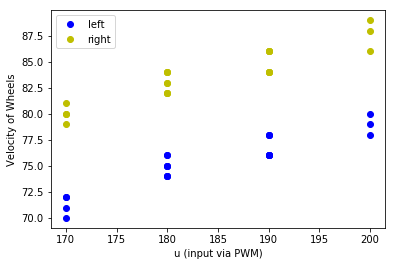

In [4]:
with open('data_fine.txt', 'r') as file:
    data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])
    
# compute velocity from distances
dleft  = data[:, 1]
dright = data[:, 2]
vleft  = dleft[1:]  - dleft[:-1] 
vright = dright[1:] - dright[:-1]
u = data[1:, 0].reshape((-1, 1)) # duty cycle

plt.plot(u, vleft, 'bo',  u, vright, 'yo')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right"), loc=0)
plt.show()

Now that we have some data, we can try performing least squares regression. Formulate the least squares problem in the cell below. The function `np.linalg.lstsq` will be helpful here. The problem formulation is nearly the same for both wheels, so we can write a function that takes the data as parameters, performs least squares, and extracts the parameters.

Record the values of $\theta$ and $\beta$ for each wheel.

In [13]:
# YOUR CODE HERE
# Write a function that formulates and performs least squares
# and returns theta and beta for one wheel

print(u)
print(u.T)

A = np.vstack([u.T, -1 * np.array([np.ones(len(u)).T])]).T

# extract parameters, call your function here
theta_left, beta_left = np.linalg.lstsq(A, vleft)[0]
theta_right, beta_right = np.linalg.lstsq(A, vright)[0]

print("float theta_left = {:.4g};".format(theta_left))
print("float theta_right = {:.4g};".format(theta_right))
print("float beta_left = {:.4g};".format(beta_left))
print("float beta_right = {:.4g};".format(beta_right))

[190 190 190 190 180 180 180 180 170 170 170 170 180 180 180 180 190 190
 190 190 200 200 200]
[190 190 190 190 180 180 180 180 170 170 170 170 180 180 180 180 190 190
 190 190 200 200 200]
float theta_left = 0.2476;
float theta_right = 0.2451;
float beta_left = -29.8;
float beta_right = -38.59;


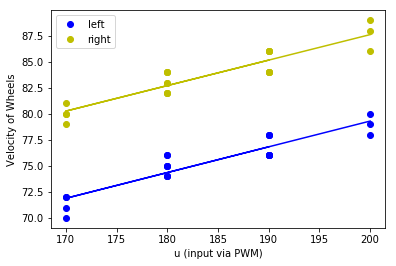

In [14]:
# plot results of least squares fit 
u = u.reshape(-1)

vleft_LS = theta_left*u-beta_left
vright_LS = theta_right*u-beta_right

plt.plot(u, vleft, 'bo',  u, vright, 'yo', u, vleft_LS, 'b-', u, vright_LS, 'y-')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right"), loc=0)

**Inspect the linearity of this plot and the coarse data plot. If you think a different range of PWM may be more linear, change HIGH_PWM and LOW_PWM in the .ino file.** However, be careful so your car does not run too close to the minimum or maximum PWM (0 and 255). If our control scheme saturates (e.g. maxes at 255) an input, the car is much harder to control.

To test that we have estimated the parameters accurately, we will simulate the model using the parameters we have found. When we compare the simulated data with the collected data, we expect them to match up pretty well. 

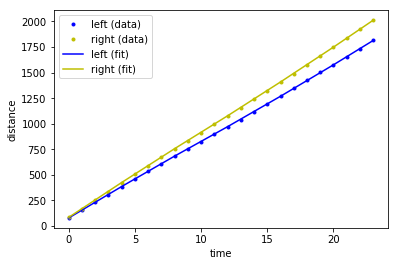

In [15]:
# model for simulation 
def sim(d0, u, theta, beta):
    d = np.zeros(len(u)+1)
    d[0] = d0
    for t in range(len(u)):
        d[t+1] = d[t] + theta*u[t] - beta
    return d
        
# plot simulated trajectories 
dleft_simulated  = sim(dleft[0], u, theta_left, beta_left)
dright_simulated = sim(dright[0], u, theta_right, beta_right)
plt.plot(dleft, 'b.', 
         dright, 'y.',
         dleft_simulated, 'b-', 
         dright_simulated, 'y-',
        )
plt.xlabel("time")
plt.ylabel("distance")
plt.legend(("left (data)", "right (data)", "left (fit)", "right (fit)"), loc='upper left')

<a id='part6'></a>
## <span style="color:blue">Part 6: Determining the Operating Point</span>

In general, each wheel may have a different range of velocities, illustrated here.

<img src="./images/partial_overlap_lsq.png">


In order to drive straight, the car must be operating at a velocity achievable by both wheels. A good choice of target velocity is the midpoint of the overlapping range of velocity. The below cell will calculate this.

Velocity range = [80.3, 79.3]

Operating point:
float v_star = 79.8;


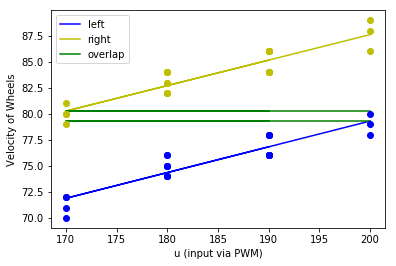

In [16]:
min_vel = max(min(vleft_LS), min(vright_LS))
max_vel = min(max(vleft_LS), max(vright_LS))
print('Velocity range = [{:0.1f}, {:0.1f}]'.format(min_vel, max_vel))
midpoint = (min_vel+max_vel)/2
print('\nOperating point:\nfloat v_star = {:.1f};'.format(midpoint))

u = u.reshape(-1)
vleft_LS = theta_left*u-beta_left
vright_LS = theta_right*u-beta_right
plt.plot(u, vleft_LS, 'b-', u, vright_LS, 'y-')
for i in (min_vel, max_vel):
    plt.plot(u, 0*u + i, 'g-')
plt.plot(u, vleft, 'bo',  u, vright, 'yo')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right", "overlap"), loc=0)

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
## <span style="color:green">CHECKOFF 1</span>
 <span style="color:green">**Show your GSI your data collection and parameters.** Your GSI will double check your parameters.</span>
 
 <span style="color:green">**Show your GSI that you have submitted the lab assignment on Gradescope and have credit for all the labs you've completed.**</span>